# Data Battle - Penerimaan Negara
Konteks kompetisi ini adalah forecasting realisasi penerimaan negara dari sektor perpajakan. 

Dataset: https://www.kaggle.com/competitions/data-battle-1/overview

In [119]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

In [120]:
df = pd.read_csv("./data_training.csv", sep=';')
print(df.head())

       Date X1   X2            Y
0  07/01/12     NaN  71864183015
1  07/01/12       A  32640358590
2  07/01/12       B  30845698143
3  07/01/12       C  39580783266
4  07/01/12       D  30442401289


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429999 entries, 0 to 429998
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    429999 non-null  object
 1   X1      429999 non-null  object
 2   X2      411191 non-null  object
 3   Y       429999 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 13.1+ MB


In [122]:
time = pd.to_datetime(df['Date'])
print(time.tail(15))

429984   2022-07-30
429985   2022-07-30
429986   2022-07-30
429987   2022-07-30
429988   2022-07-30
429989   2022-07-30
429990   2022-07-30
429991   2022-07-30
429992   2022-07-30
429993   2022-07-30
429994   2022-07-30
429995   2022-07-30
429996   2022-07-30
429997   2022-07-30
429998   2022-07-30
Name: Date, dtype: datetime64[ns]


C:\Users\Asus\AppData\Local\Temp\ipykernel_10892\731164032.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time = pd.to_datetime(df['Date'])


In [123]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

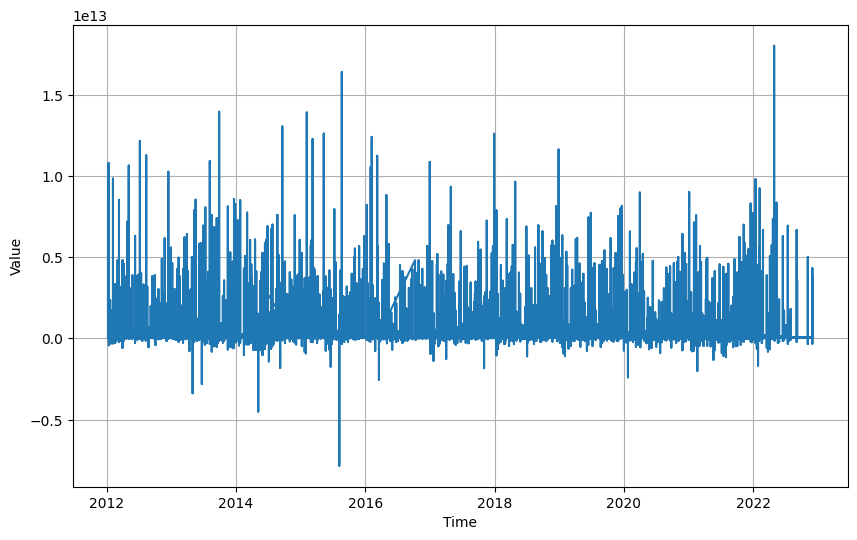

In [124]:
plot_series(time, df['Y'])

kenapa plot di atas gak terlihat seperti time series?
karena dalam satu hari itu ada beberapa records jadilah multiple values at one time step.
Makanya time perlu diconsider jadi features

In [125]:
# ignore time as feature, just use columns
def make_time_features(series):
    '''
    Extracting date and time features such as month, year, day of the week

    args:
        series (arrays of objects): date series to convert

    returns:
        hour (int): hour of 
    '''

    #convert series to datetimes
    datetimes = pd.DatetimeIndex(series, dayfirst=True)

    day = datetimes.dayofweek.values
    months = datetimes.month.values

    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')

    return dayofw, month


dayofw, month = make_time_features(df['Date'])


In [126]:
# replace field that's entirely space (or empty) with mode
cleaned_X1 = df['X1'].replace(r'^\s*$', df['X1'].mode()[0], regex=True)

# fill NAN values
cleaned_X2 = df['X2'].replace(np.NAN, df['X2'].mode()[0])

concat_df = pd.concat([df.drop(['Date', 'X1', 'X2'], axis=1), dayofw, month, cleaned_X1, cleaned_X2], axis=1)

print(concat_df.head())

             Y  dayofw  months           X1 X2
0  71864183015       5       1  Propinsi 08  G
1  32640358590       5       1  Propinsi 08  A
2  30845698143       5       1  Propinsi 08  B
3  39580783266       5       1  Propinsi 08  C
4  30442401289       5       1  Propinsi 08  D


In [127]:
one_hot_df = pd.get_dummies(concat_df, columns = ['X1', 'X2'], dtype=int)
one_hot_df = one_hot_df.astype(float)
print(one_hot_df.tail())

                   Y  dayofw  months  X1_Propinsi 01  X1_Propinsi 02  \
429994  3.348808e+10     5.0     7.0             0.0             0.0   
429995  2.977957e+10     5.0     7.0             0.0             0.0   
429996  3.230454e+10     5.0     7.0             0.0             0.0   
429997  2.974892e+10     5.0     7.0             0.0             0.0   
429998  2.976184e+10     5.0     7.0             0.0             0.0   

        X1_Propinsi 03  X1_Propinsi 04  X1_Propinsi 05  X1_Propinsi 06  \
429994             0.0             1.0             0.0             0.0   
429995             0.0             1.0             0.0             0.0   
429996             0.0             1.0             0.0             0.0   
429997             0.0             1.0             0.0             0.0   
429998             0.0             1.0             0.0             0.0   

        X1_Propinsi 07  ...  X2_M  X2_N  X2_O  X2_P  X2_Q  X2_R  X2_S  X2_T  \
429994             0.0  ...   0.0   0.0   0

In [128]:
mm = MinMaxScaler()
df_scaled = mm.fit_transform(one_hot_df)
print(df_scaled.shape)

(429999, 59)


In [59]:
# split train test
split_size = 0.8
training_size = int(len(time) * split_size)
print(training_size)

series_train = df_scaled[:training_size,:]
series_valid = df_scaled[training_size:, :]

print(series_train.shape)
print(series_valid.shape)

343999
(343999, 59)
(86000, 59)


In [60]:
def windowed_dataset(series, n_past, n_future):
    seriesX = []
    seriesY = []
    
    for i in range(n_past, len(series) - n_future +1):
        seriesX.append(series[i - n_past:i, 1:series.shape[1]])
        seriesY.append(series[i + n_future - 1:i + n_future, 0])

    seriesX, seriesY = np.array(seriesX), np.array(seriesY)
    
    return seriesX, seriesY

In [61]:
n_past = 14
n_future = 1

trainX, trainY = windowed_dataset(series_train, n_past, n_future)

print(f'Train X shape: {trainX.shape}')
print(f'Train Y shape: {trainY.shape}')

Train X shape: (343985, 14, 58)
Train Y shape: (343985, 1)


In [62]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            31488     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43937 (171.63 KB)
Trainable params: 43937 (171.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
19350/19350 [==============================] - 226s 11ms/step - loss: 1.4626e-04 - val_loss: 3.3660e-05
Epoch 2/5
19350/19350 [==============================] - 1058s 55ms/step - loss: 4.4093e-05 - val_loss: 3.3296e-05
Epoch 3/5
19350/19350 [==============================] - 228s 12ms/step - loss: 4.3787e-05 - val_loss: 3.0269e-05
Epoch 4/5
19350/19350 [==============================] - 224s 12ms/step - loss: 4.2955e-05 - val_loss: 3.2057e-05
Epoch 5/5
19350/19350 [==============================] - 222s 11ms/step - loss: 4.3667e-05 - val_loss: 3.1737e-05


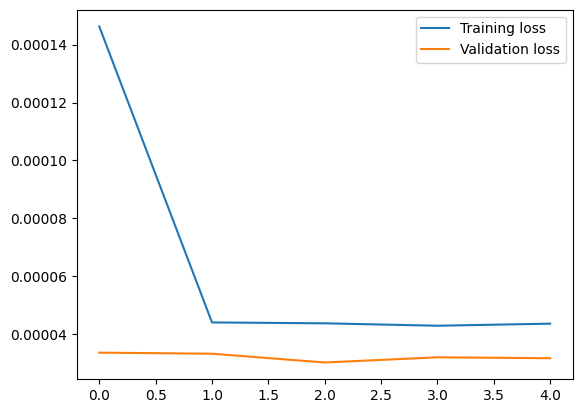

In [64]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [65]:
n_past = 14
n_future = 1

validX, validY = windowed_dataset(series_valid, n_past, n_future)

print(f'Valid X shape: {validX.shape}')
print(f'Valid Y shape: {validY.shape}')

Valid X shape: (85986, 14, 58)
Valid Y shape: (85986, 1)


In [66]:
index = [i for i in range(validY.shape[0])]

In [67]:
forecast = model.predict(validX)
print(f'Forecast shape: {forecast.shape}')

2688/2688 [==============================] - 15s 6ms/step
Forecast shape: (85986, 1)


In [68]:
y_valid_copies = np.repeat(validY, df_scaled.shape[1], axis=-1)
y_valid = mm.inverse_transform(y_valid_copies)[:,0]
y_valid

array([2.97477026e+10, 3.52637712e+10, 2.98172319e+10, ...,
       3.23045374e+10, 2.97489168e+10, 2.97618441e+10])

In [69]:
y_pred_copies = np.repeat(forecast, df_scaled.shape[1], axis=-1)
y_pred = mm.inverse_transform(y_pred_copies)[:,0]
y_pred

array([1.4844142e+10, 1.4844142e+10, 1.4844142e+10, ..., 1.4844142e+10,
       1.4844142e+10, 1.4844142e+10], dtype=float32)

In [70]:
np.unique(y_pred, return_counts=True)

(array([1.2158253e+09, 1.2543560e+09, 1.3113815e+09, ..., 3.1347976e+12,
        3.2060311e+12, 3.2315020e+12], dtype=float32),
 array([ 9,  8, 13, ...,  8,  3,  5], dtype=int64))

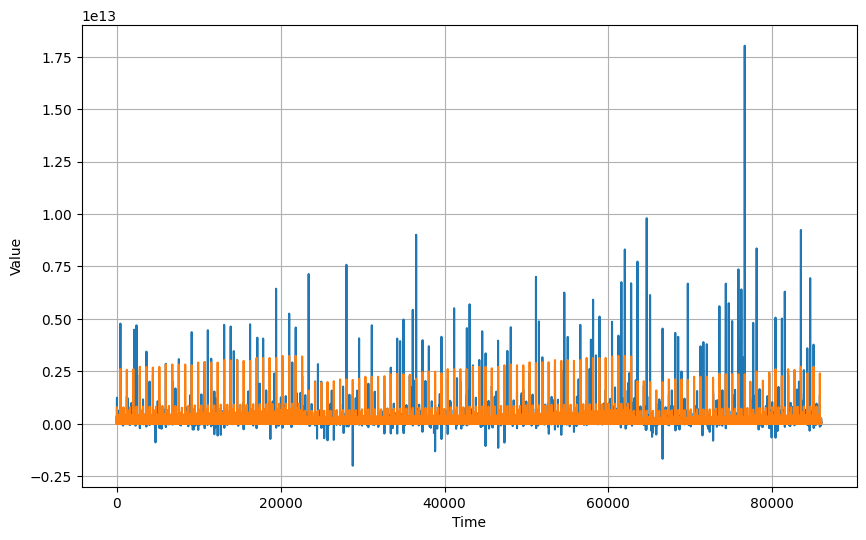

In [71]:
time_to_plot = time_valid[:-n_past]
plot_series(index, (y_valid, y_pred))

In [72]:
print(tf.keras.metrics.mean_squared_error(y_valid, y_pred).numpy())
print(tf.keras.metrics.mean_absolute_error(y_valid, y_pred).numpy())

3.388281e+22
38765707000.0


In [97]:
df_test = pd.read_csv("./data_testing.csv", sep=';')
print(df_test.head())

   id      Date           X1   X2
0  b1  30/07/22  Propinsi 04    Z
1  b2  30/07/22  Propinsi 05  NaN
2  b3  30/07/22  Propinsi 05    A
3  b4  30/07/22  Propinsi 05    B
4  b5  30/07/22  Propinsi 05    C


In [98]:
df_test.shape

(47049, 4)

In [74]:
print(df_test['X1'].isnull().sum())
print(df_test['X2'].isnull().sum())

0
2078


In [80]:
# replace field that's entirely space (or empty) with mode
test_X1 = df_test['X1'].replace(r'^\s*$', df_test['X1'].mode()[0], regex=True)

# fill NAN values
test_X2 = df_test['X2'].replace(np.NAN, df_test['X2'].mode()[0])

test_dayofw, test_month = make_time_features(df_test['Date'])

concat_df_test = pd.concat([df_test.drop(['id', 'Date', 'X1', 'X2'], axis=1), test_dayofw, test_month, test_X1, test_X2], axis=1)

print(concat_df_test.head())

   dayofw  months           X1 X2
0       5       7  Propinsi 04  Z
1       5       7  Propinsi 05  G
2       5       7  Propinsi 05  A
3       5       7  Propinsi 05  B
4       5       7  Propinsi 05  C


In [81]:
one_hot_df_test = pd.get_dummies(concat_df_test, columns = ['X1', 'X2'], dtype=int)
one_hot_df_test = one_hot_df_test.astype(float)
print(one_hot_df_test.tail())

       dayofw  months  X1_Propinsi 01  X1_Propinsi 02  X1_Propinsi 03  \
47044     5.0     9.0             0.0             0.0             0.0   
47045     5.0     9.0             0.0             0.0             0.0   
47046     5.0     9.0             0.0             0.0             0.0   
47047     5.0     9.0             0.0             0.0             0.0   
47048     5.0     9.0             0.0             0.0             0.0   

       X1_Propinsi 04  X1_Propinsi 05  X1_Propinsi 06  X1_Propinsi 07  \
47044             0.0             0.0             0.0             0.0   
47045             0.0             0.0             0.0             0.0   
47046             0.0             0.0             0.0             0.0   
47047             0.0             0.0             0.0             0.0   
47048             0.0             0.0             0.0             0.0   

       X1_Propinsi 08  ...  X2_M  X2_N  X2_O  X2_P  X2_Q  X2_R  X2_S  X2_T  \
47044             0.0  ...   0.0   0.0   0.0

In [116]:
df_test_scaled = mm.fit_transform(one_hot_df_test)
df_test_scaled

array([[0.        , 0.54545455, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.54545455, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.54545455, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.72727273, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.72727273, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.72727273, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [95]:
n_past = 14
n_future = 1
# seriesX = np.array(None)

# for i in range(n_past, len(df_test_scaled) - n_future +1):
#     seriesX.append(df_test_scaled[i - n_past:i, 0:df_test_scaled.shape[1]])

#     seriesX = np.array(seriesX)

def windowed_test(series, n_past, n_future):
    seriesX = []
    
    for i in range(n_past, len(series) - n_future +1):
        seriesX.append(series[i - n_past:i, 0:series.shape[1]])

    seriesX = np.array(seriesX)
    
    return seriesX

series_test_X = windowed_test(df_test_scaled, n_past, n_future)
series_test_X.shape

(47035, 14, 58)

In [111]:
forecast_test = model.predict(series_test_X)
print(f'Forecast shape: {forecast_test.shape}')

1470/1470 [==============================] - 8s 6ms/step
Forecast shape: (47035, 1)


In [156]:
# forecast_test = forecast_test[:n_past] + forecast_test
forecast_test2 = np.concatenate((forecast_test, forecast_test[:n_past]))
print(f'Forecast shape: {forecast_test2.shape}')

Forecast shape: (47049, 1)


In [159]:
y_test_copies = np.repeat(forecast_test2, df_scaled.shape[1], axis=-1)
y_test = mm.inverse_transform(y_test_copies)[:,0]
y_test = y_test.astype(np.int64)
y_test

array([16239724544, 14859553792, 28235878400, ..., 14845682688,
       47394123776, 95408799744], dtype=int64)

In [160]:
submitted_df = df_test.drop(['Date', 'X1', 'X2'], axis=1)
submitted_df['Y'] = y_test
submitted_df

,id,Y
0,b1,16239724544
1,b2,14859553792
2,b3,28235878400
3,b4,14899625984
4,b5,14845682688
...,...,...
47044,b47045,14844141568
47045,b47046,22354548736
47046,b47047,14845682688
47047,b47048,47394123776


In [162]:
submitted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47049 entries, 0 to 47048
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      47049 non-null  object
 1   Y       47049 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 735.3+ KB


In [103]:
sample = pd.read_csv("./sample_submission.csv", sep=',')
print(sample.head())

   id        Y
0  b1  1234567
1  b2  1234567
2  b3  1234567
3  b4  1234567
4  b5  1234567


In [164]:
submitted_df.to_csv('s.csv', sep=',', index=False)

In [165]:
subm = pd.read_csv("./s.csv", sep=',')
print(subm.head())

   id            Y
0  b1  16239724544
1  b2  14859553792
2  b3  28235878400
3  b4  14899625984
4  b5  14845682688
